# Visual Question Answering using Multimodal Transformer Models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary libraries & set up the environment

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers==4.11.2
!pip install accelerate==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
pip install transformers

In [ ]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

**These lines import various classes and functions from the Hugging Face Transformers library. This library provides pre-trained models and a collection of tools for working with natural language processing (NLP) and computer vision (CV) models.**

In [ ]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

<ipython-input-6-705839fc65d9>:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4


## Load the Processed Pathology Dataset

All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (*answer space*) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [ ]:
from datasets import load_dataset
import os

# Load the dataset
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("..", "/content/drive/MyDrive/model", "trainpvqaimg.csv"),
        "test": os.path.join("..", "/content/drive/MyDrive/model", "testpvqaimg.csv")
    }
)

with open(os.path.join("..", "/content/drive/MyDrive/model", "unique_answers.txt")) as f:
    YNSanswer_space = f.read().splitlines()

# Map function to process the dataset
def process_example(example):
    labels = []
    for ans in example['answer']:
        ans_cleaned = ans.replace(" ", "").split(",")[0]
        try:
            label = YNSanswer_space.index(ans_cleaned)
        except ValueError:
            label = -1  # or another default label
        labels.append(label)
    return {'label': labels}

# Apply the map function to the dataset
dataset = dataset.map(process_example, batched=True)

# Print the processed dataset
print(dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15086 [00:00<?, ? examples/s]

Map:   0%|          | 0/5164 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 15086
    })
    test: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 5164
    })
})


### Look at some of the Question/Image/Answer combinations

In [ ]:
from IPython.display import display
from PIL import Image
import os
import numpy as np

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id is None:
        id = np.random.randint(len(data))
    image_path = os.path.join("..", "/content/drive/MyDrive", "train", data[id]["image"] + ".jpg")
    image = Image.open(image_path)
    # Convert the image to RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

# Replace "dataset" with your actual dataset object
# Also, make sure the dataset object and other variables used in the function are defined correctly.


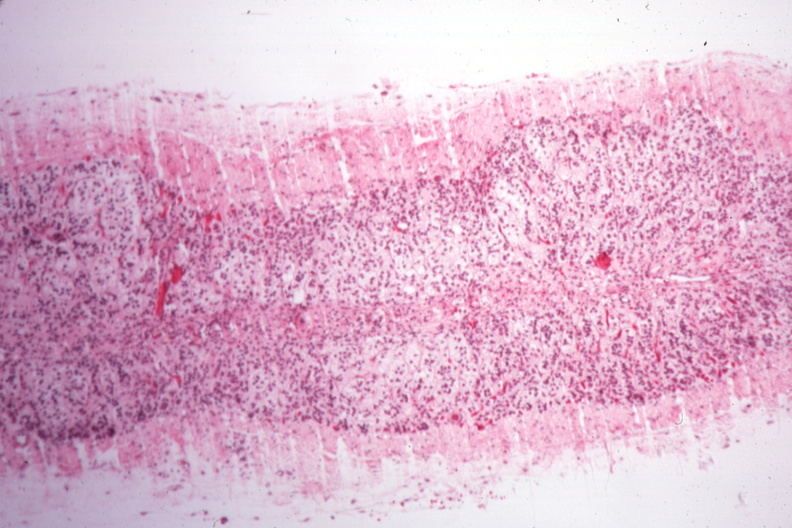

Question:	 What is present ?
Answer:		 endocrine (Label: 435)


In [ ]:
showExample()

### Create a Multimodal Collator for the Dataset

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [ ]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..", "/content/drive/MyDrive", "train",  image_id + ".jpg")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image']
                if isinstance(raw_batch_dict, dict) else
                [i['image'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we explore **"Fusion" Models**, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering).

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the *Cross-Entropy Loss* as the loss function.

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(YNSanswer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [ ]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [ ]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(YNSanswer_space[label], YNSanswer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

**This function is useful for evaluating the semantic similarity between the true and predicted labels in a batch, considering the Wu-Palmer similarity measure. The function assumes that YNSanswer_space contains the possible answers in a pre-defined space.**

In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
labels = np.random.randint(len(YNSanswer_space), size=5)
preds = np.random.randint(len(YNSanswer_space), size=5)

def showAnswers(ids):
    print([YNSanswer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['rounded', 'pharynx', 'candidiasis-erythematous', 'mesothelioma', 'abdomen']
['coronary', 'Exostosis', 'shock', 'Arachnodactyly', 'mucocele']
Predictions vs Labels:  0.0020000000000000005
Labels vs Labels:  1.0


**Here, you calculate and print the Wu-Palmer similarity scores using the batch_wup_measure function. The first line computes the similarity between the randomly generated predictions and labels, while the second line calculates the similarity between the randomly generated labels and themselves.**

In [ ]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [ ]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=10,
    fp16=False,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [ ]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..","checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [ ]:
# collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 3.3072, 'learning_rate': 4.89406779661017e-05, 'epoch': 0.21}
{'eval_loss': 2.128600597381592, 'eval_wups': 0.5040774379176616, 'eval_acc': 0.49515879163439197, 'eval_f1': 0.006130955940705376, 'eval_runtime': 130.9174, 'eval_samples_per_second': 39.445, 'eval_steps_per_second': 1.237, 'epoch': 0.21}
{'loss': 1.9769, 'learning_rate': 4.788135593220339e-05, 'epoch': 0.42}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.8277615308761597, 'eval_wups': 0.55676868652206, 'eval_acc': 0.5486057319907048, 'eval_f1': 0.008606143767764647, 'eval_runtime': 114.6232, 'eval_samples_per_second': 45.052, 'eval_steps_per_second': 1.413, 'epoch': 0.42}
{'loss': 1.8631, 'learning_rate': 4.682203389830508e-05, 'epoch': 0.64}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.6942675113677979, 'eval_wups': 0.5959133034987351, 'eval_acc': 0.5896591789310612, 'eval_f1': 0.013417344055417332, 'eval_runtime': 115.848, 'eval_samples_per_second': 44.576, 'eval_steps_per_second': 1.398, 'epoch': 0.64}
{'loss': 1.7226, 'learning_rate': 4.5762711864406784e-05, 'epoch': 0.85}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.5919755697250366, 'eval_wups': 0.6078692132562535, 'eval_acc': 0.6012780790085205, 'eval_f1': 0.017441001086111154, 'eval_runtime': 116.0301, 'eval_samples_per_second': 44.506, 'eval_steps_per_second': 1.396, 'epoch': 0.85}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 1.5446, 'learning_rate': 4.470338983050847e-05, 'epoch': 1.06}
{'eval_loss': 1.4929982423782349, 'eval_wups': 0.6388278274802494, 'eval_acc': 0.6264523625096824, 'eval_f1': 0.021248464981049674, 'eval_runtime': 114.6166, 'eval_samples_per_second': 45.055, 'eval_steps_per_second': 1.413, 'epoch': 1.06}
{'loss': 1.4605, 'learning_rate': 4.3644067796610175e-05, 'epoch': 1.27}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.420709490776062, 'eval_wups': 0.6634428802567957, 'eval_acc': 0.6522075910147173, 'eval_f1': 0.030219994454776074, 'eval_runtime': 114.6906, 'eval_samples_per_second': 45.025, 'eval_steps_per_second': 1.412, 'epoch': 1.27}
{'loss': 1.3838, 'learning_rate': 4.258474576271186e-05, 'epoch': 1.48}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3932169675827026, 'eval_wups': 0.6588737199838954, 'eval_acc': 0.6463981409759876, 'eval_f1': 0.030598363862551863, 'eval_runtime': 113.5202, 'eval_samples_per_second': 45.49, 'eval_steps_per_second': 1.427, 'epoch': 1.48}
{'loss': 1.3118, 'learning_rate': 4.152542372881356e-05, 'epoch': 1.69}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3404407501220703, 'eval_wups': 0.6732429869058421, 'eval_acc': 0.6603408210689388, 'eval_f1': 0.03394088561216373, 'eval_runtime': 115.5301, 'eval_samples_per_second': 44.698, 'eval_steps_per_second': 1.402, 'epoch': 1.69}
{'loss': 1.249, 'learning_rate': 4.0466101694915254e-05, 'epoch': 1.91}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2995163202285767, 'eval_wups': 0.6826006851749625, 'eval_acc': 0.669442292796282, 'eval_f1': 0.03949336848217813, 'eval_runtime': 116.3141, 'eval_samples_per_second': 44.397, 'eval_steps_per_second': 1.393, 'epoch': 1.91}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 1.14, 'learning_rate': 3.940677966101695e-05, 'epoch': 2.12}
{'eval_loss': 1.2670660018920898, 'eval_wups': 0.6954388933414422, 'eval_acc': 0.6849341595662277, 'eval_f1': 0.046267129230513425, 'eval_runtime': 114.7699, 'eval_samples_per_second': 44.994, 'eval_steps_per_second': 1.412, 'epoch': 2.12}
{'loss': 1.1235, 'learning_rate': 3.8347457627118644e-05, 'epoch': 2.33}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2648735046386719, 'eval_wups': 0.7022812055987968, 'eval_acc': 0.6909372579395817, 'eval_f1': 0.048618967871921756, 'eval_runtime': 117.565, 'eval_samples_per_second': 43.925, 'eval_steps_per_second': 1.378, 'epoch': 2.33}
{'loss': 1.0786, 'learning_rate': 3.728813559322034e-05, 'epoch': 2.54}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2706634998321533, 'eval_wups': 0.6954365075816988, 'eval_acc': 0.6855151045701007, 'eval_f1': 0.05095494581133857, 'eval_runtime': 116.1043, 'eval_samples_per_second': 44.477, 'eval_steps_per_second': 1.395, 'epoch': 2.54}
{'loss': 0.9875, 'learning_rate': 3.6228813559322035e-05, 'epoch': 2.75}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2215337753295898, 'eval_wups': 0.7093069489373872, 'eval_acc': 0.6988768396591789, 'eval_f1': 0.05065904012158189, 'eval_runtime': 114.9808, 'eval_samples_per_second': 44.912, 'eval_steps_per_second': 1.409, 'epoch': 2.75}
{'loss': 0.9734, 'learning_rate': 3.516949152542373e-05, 'epoch': 2.97}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2031625509262085, 'eval_wups': 0.7145977120649901, 'eval_acc': 0.703718048024787, 'eval_f1': 0.05896334672289163, 'eval_runtime': 116.5002, 'eval_samples_per_second': 44.326, 'eval_steps_per_second': 1.391, 'epoch': 2.97}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.8902, 'learning_rate': 3.4110169491525426e-05, 'epoch': 3.18}
{'eval_loss': 1.2492161989212036, 'eval_wups': 0.7167662915829173, 'eval_acc': 0.7072037180480247, 'eval_f1': 0.057674904481646284, 'eval_runtime': 119.4213, 'eval_samples_per_second': 43.242, 'eval_steps_per_second': 1.357, 'epoch': 3.18}
{'loss': 0.8705, 'learning_rate': 3.305084745762712e-05, 'epoch': 3.39}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2201460599899292, 'eval_wups': 0.7240078401963056, 'eval_acc': 0.713400464756003, 'eval_f1': 0.05974661021358096, 'eval_runtime': 119.5689, 'eval_samples_per_second': 43.189, 'eval_steps_per_second': 1.355, 'epoch': 3.39}
{'loss': 0.8304, 'learning_rate': 3.199152542372881e-05, 'epoch': 3.6}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.20721435546875, 'eval_wups': 0.7229588382869293, 'eval_acc': 0.7122385747482571, 'eval_f1': 0.06521687719817869, 'eval_runtime': 117.6948, 'eval_samples_per_second': 43.876, 'eval_steps_per_second': 1.376, 'epoch': 3.6}
{'loss': 0.8949, 'learning_rate': 3.093220338983051e-05, 'epoch': 3.81}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.1687324047088623, 'eval_wups': 0.7206919361531289, 'eval_acc': 0.7108830364058869, 'eval_f1': 0.06369818114773176, 'eval_runtime': 120.7002, 'eval_samples_per_second': 42.784, 'eval_steps_per_second': 1.342, 'epoch': 3.81}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.8193, 'learning_rate': 2.9872881355932204e-05, 'epoch': 4.03}
{'eval_loss': 1.2325485944747925, 'eval_wups': 0.7193370227728076, 'eval_acc': 0.7104957397366383, 'eval_f1': 0.06819961803956309, 'eval_runtime': 118.4533, 'eval_samples_per_second': 43.595, 'eval_steps_per_second': 1.368, 'epoch': 4.03}
{'loss': 0.7403, 'learning_rate': 2.88135593220339e-05, 'epoch': 4.24}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.1828030347824097, 'eval_wups': 0.7300425717048662, 'eval_acc': 0.7203718048024786, 'eval_f1': 0.07224986368878784, 'eval_runtime': 115.8472, 'eval_samples_per_second': 44.576, 'eval_steps_per_second': 1.398, 'epoch': 4.24}
{'loss': 0.7475, 'learning_rate': 2.775423728813559e-05, 'epoch': 4.45}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2071090936660767, 'eval_wups': 0.7258573036859602, 'eval_acc': 0.7155305964368707, 'eval_f1': 0.07132933806131243, 'eval_runtime': 118.3726, 'eval_samples_per_second': 43.625, 'eval_steps_per_second': 1.369, 'epoch': 4.45}
{'loss': 0.7536, 'learning_rate': 2.669491525423729e-05, 'epoch': 4.66}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.1979840993881226, 'eval_wups': 0.7339598581478579, 'eval_acc': 0.7228892331525949, 'eval_f1': 0.06822189908642727, 'eval_runtime': 121.2113, 'eval_samples_per_second': 42.603, 'eval_steps_per_second': 1.337, 'epoch': 4.66}
{'loss': 0.7484, 'learning_rate': 2.5635593220338982e-05, 'epoch': 4.87}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2000980377197266, 'eval_wups': 0.7330310485470672, 'eval_acc': 0.7219209914794733, 'eval_f1': 0.07287352897715499, 'eval_runtime': 121.9193, 'eval_samples_per_second': 42.356, 'eval_steps_per_second': 1.329, 'epoch': 4.87}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.6887, 'learning_rate': 2.457627118644068e-05, 'epoch': 5.08}
{'eval_loss': 1.1923387050628662, 'eval_wups': 0.7352467599105087, 'eval_acc': 0.7244384198295895, 'eval_f1': 0.07164122740196731, 'eval_runtime': 118.842, 'eval_samples_per_second': 43.453, 'eval_steps_per_second': 1.363, 'epoch': 5.08}
{'loss': 0.6783, 'learning_rate': 2.3516949152542376e-05, 'epoch': 5.3}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.239697813987732, 'eval_wups': 0.7370526611374866, 'eval_acc': 0.72714949651433, 'eval_f1': 0.07493340159440924, 'eval_runtime': 121.8339, 'eval_samples_per_second': 42.386, 'eval_steps_per_second': 1.33, 'epoch': 5.3}
{'loss': 0.6652, 'learning_rate': 2.245762711864407e-05, 'epoch': 5.51}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2462815046310425, 'eval_wups': 0.7360524898009133, 'eval_acc': 0.725406661502711, 'eval_f1': 0.07643438086086597, 'eval_runtime': 120.2878, 'eval_samples_per_second': 42.93, 'eval_steps_per_second': 1.347, 'epoch': 5.51}
{'loss': 0.6949, 'learning_rate': 2.1398305084745763e-05, 'epoch': 5.72}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2044792175292969, 'eval_wups': 0.7400922855976168, 'eval_acc': 0.731409759876065, 'eval_f1': 0.07878531704936653, 'eval_runtime': 118.4205, 'eval_samples_per_second': 43.607, 'eval_steps_per_second': 1.368, 'epoch': 5.72}
{'loss': 0.6897, 'learning_rate': 2.033898305084746e-05, 'epoch': 5.93}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2510106563568115, 'eval_wups': 0.736044627113598, 'eval_acc': 0.725987606506584, 'eval_f1': 0.07778891144828083, 'eval_runtime': 117.5005, 'eval_samples_per_second': 43.949, 'eval_steps_per_second': 1.379, 'epoch': 5.93}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.6128, 'learning_rate': 1.9279661016949154e-05, 'epoch': 6.14}
{'eval_loss': 1.2775665521621704, 'eval_wups': 0.735163083364872, 'eval_acc': 0.7244384198295895, 'eval_f1': 0.07836163259594191, 'eval_runtime': 116.5772, 'eval_samples_per_second': 44.297, 'eval_steps_per_second': 1.39, 'epoch': 6.14}
{'loss': 0.6152, 'learning_rate': 1.8220338983050846e-05, 'epoch': 6.36}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2294878959655762, 'eval_wups': 0.7399546444209028, 'eval_acc': 0.7300542215336948, 'eval_f1': 0.0797821275750615, 'eval_runtime': 121.461, 'eval_samples_per_second': 42.516, 'eval_steps_per_second': 1.334, 'epoch': 6.36}
{'loss': 0.6628, 'learning_rate': 1.716101694915254e-05, 'epoch': 6.57}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2510130405426025, 'eval_wups': 0.7379705403111928, 'eval_acc': 0.7281177381874516, 'eval_f1': 0.08294659841087368, 'eval_runtime': 119.733, 'eval_samples_per_second': 43.129, 'eval_steps_per_second': 1.353, 'epoch': 6.57}
{'loss': 0.5833, 'learning_rate': 1.6101694915254237e-05, 'epoch': 6.78}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2675726413726807, 'eval_wups': 0.7384322398553973, 'eval_acc': 0.7279240898528273, 'eval_f1': 0.07754337028856541, 'eval_runtime': 118.6353, 'eval_samples_per_second': 43.528, 'eval_steps_per_second': 1.366, 'epoch': 6.78}
{'loss': 0.596, 'learning_rate': 1.5042372881355932e-05, 'epoch': 6.99}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2271504402160645, 'eval_wups': 0.7386487169850161, 'eval_acc': 0.7294732765298219, 'eval_f1': 0.08038390742506349, 'eval_runtime': 117.3447, 'eval_samples_per_second': 44.007, 'eval_steps_per_second': 1.381, 'epoch': 6.99}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.5952, 'learning_rate': 1.3983050847457627e-05, 'epoch': 7.2}
{'eval_loss': 1.2677396535873413, 'eval_wups': 0.7412560864537456, 'eval_acc': 0.7312161115414407, 'eval_f1': 0.07858568175388383, 'eval_runtime': 116.2746, 'eval_samples_per_second': 44.412, 'eval_steps_per_second': 1.393, 'epoch': 7.2}
{'loss': 0.537, 'learning_rate': 1.2923728813559321e-05, 'epoch': 7.42}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3009941577911377, 'eval_wups': 0.7363215465729853, 'eval_acc': 0.7261812548412083, 'eval_f1': 0.07679466626694041, 'eval_runtime': 117.2311, 'eval_samples_per_second': 44.05, 'eval_steps_per_second': 1.382, 'epoch': 7.42}
{'loss': 0.5942, 'learning_rate': 1.1864406779661018e-05, 'epoch': 7.63}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.249052882194519, 'eval_wups': 0.7390410801634727, 'eval_acc': 0.7300542215336948, 'eval_f1': 0.0830869144472431, 'eval_runtime': 120.2556, 'eval_samples_per_second': 42.942, 'eval_steps_per_second': 1.347, 'epoch': 7.63}
{'loss': 0.5627, 'learning_rate': 1.0805084745762714e-05, 'epoch': 7.84}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2879595756530762, 'eval_wups': 0.7452910456630137, 'eval_acc': 0.7350890782339272, 'eval_f1': 0.07952204156263852, 'eval_runtime': 117.154, 'eval_samples_per_second': 44.079, 'eval_steps_per_second': 1.383, 'epoch': 7.84}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.5774, 'learning_rate': 9.745762711864407e-06, 'epoch': 8.05}
{'eval_loss': 1.2829056978225708, 'eval_wups': 0.7426652766583456, 'eval_acc': 0.7333462432223082, 'eval_f1': 0.08356962889627775, 'eval_runtime': 118.5616, 'eval_samples_per_second': 43.555, 'eval_steps_per_second': 1.366, 'epoch': 8.05}
{'loss': 0.5489, 'learning_rate': 8.686440677966103e-06, 'epoch': 8.26}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2984775304794312, 'eval_wups': 0.7421077955831703, 'eval_acc': 0.731990704879938, 'eval_f1': 0.08240459913404331, 'eval_runtime': 119.2938, 'eval_samples_per_second': 43.288, 'eval_steps_per_second': 1.358, 'epoch': 8.26}
{'loss': 0.5718, 'learning_rate': 7.627118644067798e-06, 'epoch': 8.47}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3150372505187988, 'eval_wups': 0.7411812514951748, 'eval_acc': 0.731409759876065, 'eval_f1': 0.07977227163915918, 'eval_runtime': 120.6481, 'eval_samples_per_second': 42.802, 'eval_steps_per_second': 1.343, 'epoch': 8.47}
{'loss': 0.5496, 'learning_rate': 6.567796610169492e-06, 'epoch': 8.69}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.350551724433899, 'eval_wups': 0.7410309586532638, 'eval_acc': 0.7312161115414407, 'eval_f1': 0.07905591457345273, 'eval_runtime': 116.0003, 'eval_samples_per_second': 44.517, 'eval_steps_per_second': 1.397, 'epoch': 8.69}
{'loss': 0.508, 'learning_rate': 5.508474576271187e-06, 'epoch': 8.9}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3048597574234009, 'eval_wups': 0.7450596225576197, 'eval_acc': 0.7347017815646786, 'eval_f1': 0.08466142112385994, 'eval_runtime': 118.7122, 'eval_samples_per_second': 43.5, 'eval_steps_per_second': 1.365, 'epoch': 8.9}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 0.5256, 'learning_rate': 4.449152542372881e-06, 'epoch': 9.11}
{'eval_loss': 1.3388519287109375, 'eval_wups': 0.7421532134255171, 'eval_acc': 0.732571649883811, 'eval_f1': 0.08229439303714584, 'eval_runtime': 119.7787, 'eval_samples_per_second': 43.113, 'eval_steps_per_second': 1.352, 'epoch': 9.11}
{'loss': 0.5052, 'learning_rate': 3.3898305084745763e-06, 'epoch': 9.32}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.315356969833374, 'eval_wups': 0.7437566830087189, 'eval_acc': 0.7339271882261813, 'eval_f1': 0.08347227880772291, 'eval_runtime': 116.7087, 'eval_samples_per_second': 44.247, 'eval_steps_per_second': 1.388, 'epoch': 9.32}
{'loss': 0.538, 'learning_rate': 2.3305084745762712e-06, 'epoch': 9.53}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3297853469848633, 'eval_wups': 0.7417595022120741, 'eval_acc': 0.7321843532145623, 'eval_f1': 0.08346361538316267, 'eval_runtime': 119.125, 'eval_samples_per_second': 43.349, 'eval_steps_per_second': 1.36, 'epoch': 9.53}
{'loss': 0.4754, 'learning_rate': 1.2711864406779662e-06, 'epoch': 9.75}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3292895555496216, 'eval_wups': 0.7393374917478858, 'eval_acc': 0.7302478698683191, 'eval_f1': 0.08280817034513627, 'eval_runtime': 120.8119, 'eval_samples_per_second': 42.744, 'eval_steps_per_second': 1.341, 'epoch': 9.75}
{'loss': 0.535, 'learning_rate': 2.1186440677966102e-07, 'epoch': 9.96}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.3303488492965698, 'eval_wups': 0.7408544718763219, 'eval_acc': 0.731409759876065, 'eval_f1': 0.08218757967559977, 'eval_runtime': 117.0989, 'eval_samples_per_second': 44.099, 'eval_steps_per_second': 1.383, 'epoch': 9.96}
{'train_runtime': 12395.1689, 'train_samples_per_second': 12.171, 'train_steps_per_second': 0.381, 'train_loss': 0.9034183358742018, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 1.2879595756530762, 'eval_wups': 0.7452910456630137, 'eval_acc': 0.7350890782339272, 'eval_f1': 0.07952204156263852, 'eval_runtime': 116.0221, 'eval_samples_per_second': 44.509, 'eval_steps_per_second': 1.396, 'epoch': 10.0}


In [ ]:
eval_multi_metrics

{'eval_loss': 1.2879595756530762,
 'eval_wups': 0.7452910456630137,
 'eval_acc': 0.7350890782339272,
 'eval_f1': 0.07952204156263852,
 'eval_runtime': 116.0221,
 'eval_samples_per_second': 44.509,
 'eval_steps_per_second': 1.396,
 'epoch': 10.0}

In [ ]:
# import pickle

# # ... (other code)

# # Save the model to a .pkl file
# model_filepath = "model.pkl"
# with open(model_filepath, 'wb') as model_file:
#     pickle.dump(model, model_file)


In [ ]:
import pickle

# Assuming you have already executed the createAndTrainModel function
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

# Save the variables to a pickle file
with open('model_data.pkl', 'wb') as file:
    pickle.dump((collator, model, train_multi_metrics, eval_multi_metrics), file)

In [ ]:
import pickle

# Load the variables from the pickle file
with open('model_data.pkl', 'rb') as file:
    collator, model, train_multi_metrics, eval_multi_metrics = pickle.load(file)

In [ ]:
sample = collator(dataset["test"][3432:3437])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [ ]:
import pickle

# ... (other code)

# Load the model from the .pkl file
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
# Move the model to the GPU if available

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.to(device)
# Set the loaded model to

# Set the loaded model to evaluation mode
loaded_model.eval()

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

*********************************************************


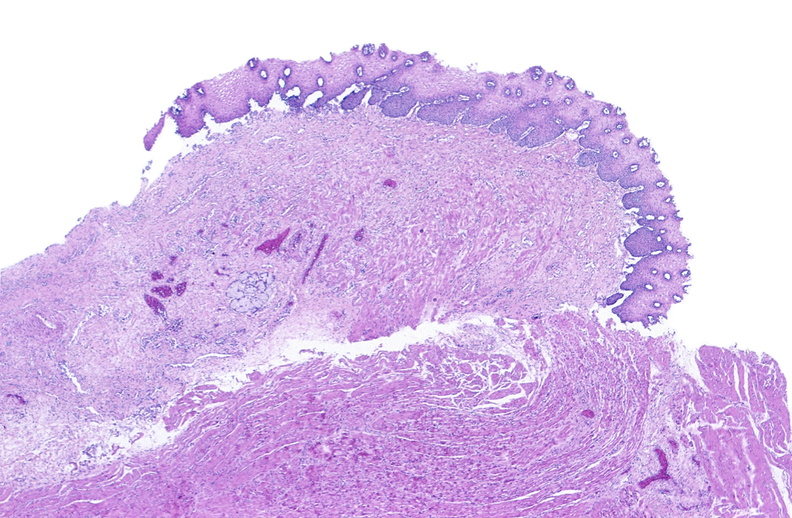

Question:	 Does gout show esophagus?
Answer:		 no (Label: 143)
Predicted Answer:	 no
*********************************************************
*********************************************************


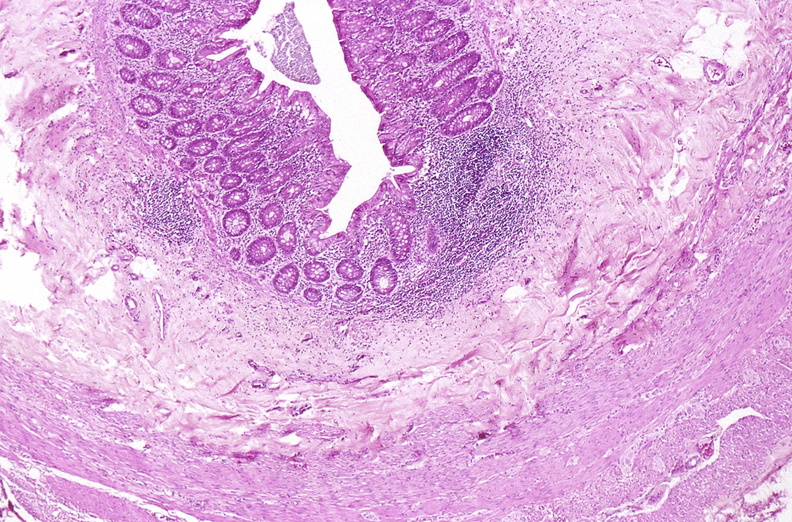

Question:	 What does this image show?
Answer:		 appendix (Label: 526)
Predicted Answer:	 colon
*********************************************************
*********************************************************


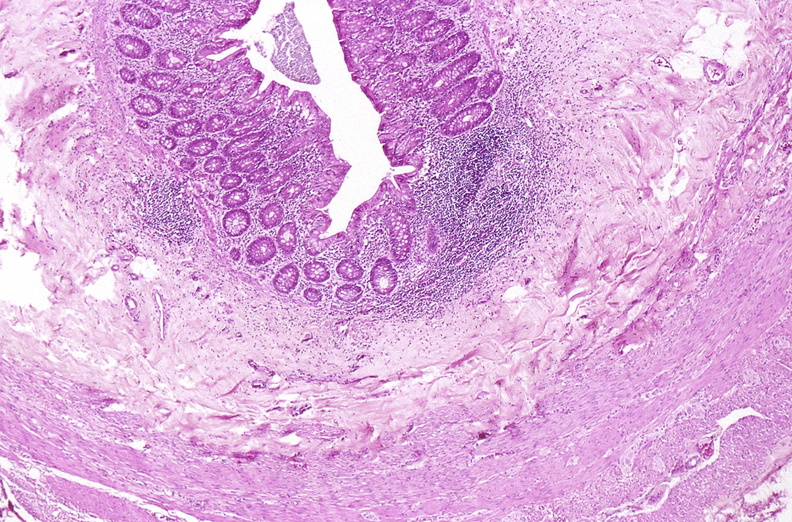

Question:	 Is gastrointestinal present?
Answer:		 yes (Label: 359)
Predicted Answer:	 yes
*********************************************************
*********************************************************


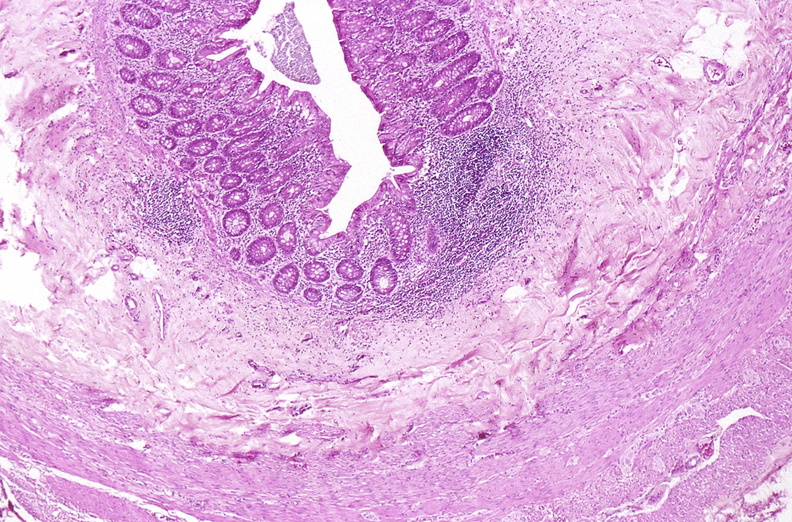

Question:	 What is present ?
Answer:		 gastrointestinal (Label: 385)
Predicted Answer:	 gastrointestinal
*********************************************************
*********************************************************


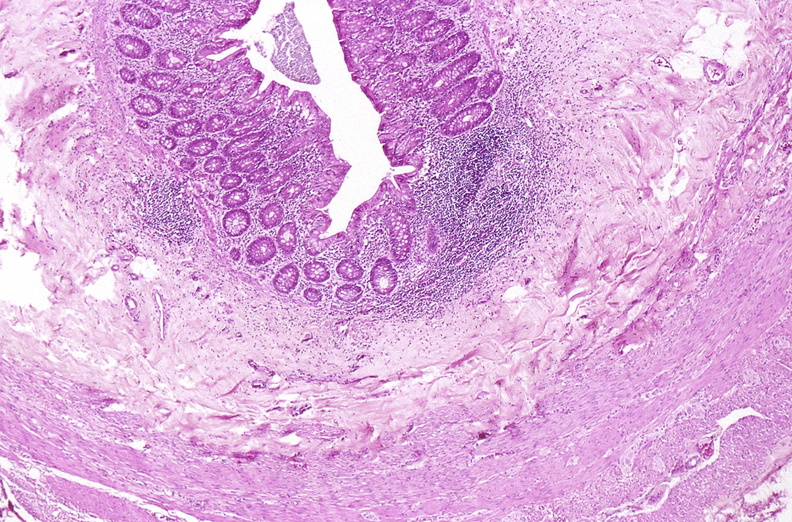

Question:	 Is foot present?
Answer:		 no (Label: 143)
Predicted Answer:	 no
*********************************************************


In [ ]:


# Continue with your inference using the loaded model
loaded_output = loaded_model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

loaded_preds = loaded_output["logits"].argmax(axis=-1).cpu().numpy()

for i in range(3432, 3437):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", YNSanswer_space[loaded_preds[i-3432]])
    print("*********************************************************")


## Examples of Model Inferencing

### Loading the Model from Checkpoint

### Pass the Samples through the Model & inspect the Predictions

## Inspecting Model Size

In [ ]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [ ]:
countTrainableParameters(loaded_model) # For BERT-ViT model